# BTSnoop Log Sniffer

This notebook demonstrates the process of parsing bluetooth packet data from android hci logs.

In [28]:
!pip install fpdf
!pip install kaleido
!pip install dataframe_image

  Using cached kaleido-0.2.1-py2.py3-none-manylinux1_x86_64.whl.metadata (15 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 17.3 MB/s eta 0:00:0000:0100:01


In [63]:
import fpdf
from fpdf import FPDF
import dataframe_image as dfi
import matplotlib.pyplot as plt
import time 

import binascii
import btsnoop
import btsnoop.bt.hci as hci
import btsnoop.btsnoop.btsnoop as bts
import btsnoop.bt.hci_uart as hci_uart
import btsnoop.bt.hci_cmd as hci_cmd
import btsnoop.bt.hci_evt as hci_evt
import btsnoop.bt.hci_acl as hci_acl
import btsnoop.bt.hci_sco as hci_sco
import btsnoop.bt.l2cap as l2cap
import btsnoop.bt.att as att
import btsnoop.bt.smp as smp
import pandas as pd
from pprint import pprint

pd.set_option('display.max_columns', None)

records = bts.parse("./bt_logfiles/btsnoop_hci_10022024_1930.log")

# TODO: SQLite storage for known devices

btsnoop capture file version 1, type 1002


In [96]:
rows = []
for record in records:
    row = {}
    seq = record[0]
    packet_length = record[1]
    flags_raw = record[2]
    flags = bts.flags_to_str(flags_raw)
    pkt_src = flags[0].capitalize()
    pkt_dst = flags[1].capitalize()
    pkt_type = flags[2]
    time = record[3].strftime("%m-%d-%Y %H:%M:%S.%f")
    pkt_data = record[4]

    direction = bts.flags_to_direction(flags_raw)

    hci_pkt_type, hci_pkt_data = hci_uart.parse(record[4])
    hci_type = hci_uart.type_to_str(hci_pkt_type)

    row.update({'sequence_number': seq,
         'packet_length': packet_length,
         'time_rcvd': time,
         'packet_source': pkt_src,
         'packet_destination': pkt_dst,
         'hci_packet_type': hci_type,
         'hci_packet_code': hci_pkt_type,
         'packet_data_unparsed': pkt_data,
         })

    if hci_pkt_type == hci_uart.HCI_CMD:
        opcode, length, data = hci_cmd.parse(hci_pkt_data)
        cmd_evt_l2cap = hci_cmd.cmd_to_str(opcode)
        parsed_data = binascii.hexlify(data)
        row.update({'opcode':opcode,
                    'length':length,
                    'hci_cmd_data':data,
                    'parsed_data':parsed_data,
                    'cmd_evt_l2cap':cmd_evt_l2cap})
    elif hci_pkt_type == hci_uart.HCI_EVT:
        hci_data = hci_evt.parse(hci_pkt_data)
        evtcode, data = hci_data[0], hci_data[-1]
        cmd_evt_l2cap = hci_evt.evt_to_str(evtcode)
        parsed_data = binascii.hexlify(data)
        row.update({'event_code':evtcode,
                    'hci_evt_data':data,
                    'parsed_data':parsed_data,
                    'cmd_evt_l2cap':cmd_evt_l2cap})
    elif hci_pkt_type == hci_uart.SCO_DATA:
        handle, ps, length, data = hci_sco.parse(hci_pkt_data)

        l2cap_length, l2cap_cid, l2cap_data = l2cap.parse(hci_data[2], data)
        data = binascii.hexlify(data)
        data = len(data) > 30 and data[:30] + "..." or data

        row.update({'handle':handle,
                    'ps':ps,
                    'length':length,
                    'data':data})
        # print(handle, ps, length, data)
        raise Exception('DEBUG: SCO Data!')
    elif hci_pkt_type == hci_uart.ACL_DATA:
        hci_data = hci_acl.parse(hci_pkt_data)
        l2cap_length, l2cap_cid, l2cap_data = l2cap.parse(hci_data[2], hci_data[4])
        row.update({'l2cap_length':l2cap_length,
                    'l2cap_cid':l2cap_cid,
                    'l2cap_data':l2cap_data})

        if l2cap_cid == l2cap.L2CAP_CID_LE_ATT:
            att_opcode, att_data = att.parse(l2cap_data)
            cmd_evt_l2cap = att.opcode_to_str(att_opcode, att_data)
            data = att_data
            parsed_data = binascii.hexlify(data)
            row.update({'att_opcode':att_opcode,
                        'cmd_evt_l2cap':cmd_evt_l2cap,
                        'parsed_data':parsed_data,
                        'data':data})

        elif l2cap_cid == l2cap.L2CAP_CID_LE_SMP:
            smp_code, smp_data = smp.parse(l2cap_data)
            cmd_evt_l2cap = smp.code_to_str(smp_code)
            data = smp_data
            parsed_data = binascii.hexlify(data)
            row.update({'smp_code':smp_code,
                        'cmd_evt_l2cap':cmd_evt_l2cap,
                        'parsed_data':parsed_data,
                        'data':data})

        elif l2cap_cid == l2cap.L2CAP_CID_LE_SCH:
            sch_code, sch_id, sch_length, sch_data = l2cap.parse_sch(l2cap_data)
            cmd_evt_l2cap = l2cap.sch_code_to_str(sch_code)
            data = sch_data
            row.update({'sch_code':sch_code,
                        'sch_id':sch_id,
                        'sch_length':sch_length,
                        'sch_data':sch_data,
                        'cmd_evt_l2cap':cmd_evt_l2cap,
                        'data':data})
    else:
        raise Exception('Unknown HCI Packet Type')

    rows.append(row)

    

[source](https://github.com/nccgroup/BLE-Replay/blob/master/btsnoop/btsnoop/bt/hci_evt.py)

The HCI LE Meta Event is used to encapsulate all LE Controller specific events.
The Event Code of all LE Meta Events shall be 0x3E. The Subevent_Code is
the first octet of the event parameters. The Subevent_Code shall be set to one
of the valid Subevent_Codes from an LE specific event


HCI inherently cannot differentiate between packet types. Hence a common physical interface is used with the indicators that are sent right before the packet is sent. These indicators are as follows

| HCI Packet Type | HCI Packet Indicator |
| --------------- | -------------------- |
| HCI Command Packet | 0x01 |
| HCI ACL Data Packet | 0x02 |
| HCI Synchronous Data Packet | 0x03 |
| HCI Event Packet | 0x04 |
| HCI ISO Data Packet | 0x05 |

LE Meta events encapsulate all LE Controller events and have a code of 0x03

[Reference](https://datatracker.ietf.org/doc/html/rfc1761)

Android bluetooth logs come in the **Snoop Version 1 Packet Capture File Format** which is similar to the second version developed by Sun Microsystems in 1995. When we capture logs of this format, we obtain arrays of octets (8 bit packets of information), with each array item corresponding to a packet record.


In [97]:
ble_data = pd.DataFrame(rows)
ble_data.columns

Index(['sequence_number', 'packet_length', 'time_rcvd', 'packet_source',
       'packet_destination', 'hci_packet_type', 'hci_packet_code',
       'packet_data_unparsed', 'event_code', 'hci_evt_data', 'parsed_data',
       'cmd_evt_l2cap', 'l2cap_length', 'l2cap_cid', 'l2cap_data', 'opcode',
       'length', 'hci_cmd_data', 'att_opcode', 'data', 'sch_code', 'sch_id',
       'sch_length', 'sch_data'],
      dtype='object')

In [98]:
ble_data[ble_data['hci_packet_type'] == 'HCI_EVT'].dropna(axis=1, how='all').head()

,sequence_number,packet_length,time_rcvd,packet_source,packet_destination,hci_packet_type,hci_packet_code,packet_data_unparsed,event_code,hci_evt_data,parsed_data,cmd_evt_l2cap
0,1,47,10-02-2024 17:34:02.987322,Controller,Host,HCI_EVT,4,"b'\x04>,\r\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,b'\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...,b'011b0001cb3919dde36c0100ff7fc000000000000000...,EVENT LE_Meta_Event (0x3e)
1,2,57,10-02-2024 17:34:03.149816,Controller,Host,HCI_EVT,4,"b""\x04>6\r\x01\x13\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,"b""\x01\x13\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...",b'01130001cb3919dde36c0100ff7fc400000000000000...,EVENT LE_Meta_Event (0x3e)
2,3,47,10-02-2024 17:34:03.151213,Controller,Host,HCI_EVT,4,"b'\x04>,\r\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,b'\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...,b'011b0001cb3919dde36c0100ff7fc400000000000000...,EVENT LE_Meta_Event (0x3e)
3,4,57,10-02-2024 17:34:03.311777,Controller,Host,HCI_EVT,4,"b""\x04>6\r\x01\x13\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,"b""\x01\x13\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...",b'01130001cb3919dde36c0100ff7fc100000000000000...,EVENT LE_Meta_Event (0x3e)
4,5,47,10-02-2024 17:34:03.313999,Controller,Host,HCI_EVT,4,"b'\x04>,\r\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,b'\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...,b'011b0001cb3919dde36c0100ff7fc000000000000000...,EVENT LE_Meta_Event (0x3e)


In [89]:
ble_data['hci_packet_type'].unique()

array(['HCI_EVT', 'ACL_DATA', 'HCI_CMD'], dtype=object)

In [95]:
# att_data = ble_data[(ble_data['hci_packet_type'] == 'ACL_DATA') & (ble_data['l2cap_cid'] == l2cap.L2CAP_CID_LE_ATT)].dropna(axis=1, how='all')
# acl_data = ble_data[(ble_data['hci_packet_type'] == 'ACL_DATA') & ~ (ble_data['att_opcode'].isna())].dropna(axis=1, how='all')
acl_data = ble_data[(ble_data['hci_packet_type'] == 'ACL_DATA')].dropna(axis=1, how='all')
acl_data.head()

,sequence_number,packet_length,time_rcvd,packet_source,packet_destination,hci_packet_type,hci_packet_code,packet_data_unparsed,cmd_evt_l2cap,l2cap_length,l2cap_cid,l2cap_data,att_opcode,data,sch_code,sch_id,sch_length,sch_data
55,56,14,2024-10-02 17:34:09.550175,Controller,Host,ACL_DATA,2,b'\x02\x0b \t\x00\x05\x00E\x00\xd0\r\x08\x08\xfc',NaN,5.0,69.0,b'\xd0\r\x08\x08\xfc',NaN,NaN,NaN,NaN,NaN,NaN
56,57,11,2024-10-02 17:34:09.552428,Host,Controller,ACL_DATA,2,b'\x02\x0b\x00\x06\x00\x02\x00A\x00\xd2\r',NaN,2.0,65.0,b'\xd2\r',NaN,NaN,NaN,NaN,NaN,NaN
79,80,14,2024-10-02 17:34:11.894999,Controller,Host,ACL_DATA,2,b'\x02\x0b \t\x00\x05\x00E\x00\xe0\r\x08\t\xe2',NaN,5.0,69.0,b'\xe0\r\x08\t\xe2',NaN,NaN,NaN,NaN,NaN,NaN
80,81,11,2024-10-02 17:34:11.897429,Host,Controller,ACL_DATA,2,b'\x02\x0b\x00\x06\x00\x02\x00A\x00\xe2\r',NaN,2.0,65.0,b'\xe2\r',NaN,NaN,NaN,NaN,NaN,NaN
209,210,34,2024-10-02 17:34:32.592301,Controller,Host,ACL_DATA,2,b'\x02\x0b \x1d\x00\x19\x00A\x00\x99\xef+AT+IP...,NaN,25.0,65.0,"b'\x99\xef+AT+IPHONEACCEV=1,1,6\r\xfd'",NaN,NaN,NaN,NaN,NaN,NaN


In [91]:
hci_evt_data = ble_data[(ble_data['hci_packet_type'] == 'HCI_EVT')].dropna(axis=1, how='all')
hci_evt_data.head()

,sequence_number,packet_length,time_rcvd,packet_source,packet_destination,hci_packet_type,hci_packet_code,packet_data_unparsed,event_code,HCI_EVT_data,cmd_evt_l2cap
0,1,47,10-02-2024 17:34:02.987322,Controller,Host,HCI_EVT,4,"b'\x04>,\r\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,b'\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...,EVENT LE_Meta_Event (0x3e)
1,2,57,10-02-2024 17:34:03.149816,Controller,Host,HCI_EVT,4,"b""\x04>6\r\x01\x13\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,"b""\x01\x13\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...",EVENT LE_Meta_Event (0x3e)
2,3,47,10-02-2024 17:34:03.151213,Controller,Host,HCI_EVT,4,"b'\x04>,\r\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,b'\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...,EVENT LE_Meta_Event (0x3e)
3,4,57,10-02-2024 17:34:03.311777,Controller,Host,HCI_EVT,4,"b""\x04>6\r\x01\x13\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,"b""\x01\x13\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...",EVENT LE_Meta_Event (0x3e)
4,5,47,10-02-2024 17:34:03.313999,Controller,Host,HCI_EVT,4,"b'\x04>,\r\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x...",62.0,b'\x01\x1b\x00\x01\xcb9\x19\xdd\xe3l\x01\x00\x...,EVENT LE_Meta_Event (0x3e)


In [94]:
hci_cmd_data = ble_data[(ble_data['hci_packet_type'] == 'HCI_CMD')].dropna(axis=1, how='all')
hci_cmd_data.head()

,sequence_number,packet_length,time_rcvd,packet_source,packet_destination,hci_packet_type,hci_packet_code,packet_data_unparsed,cmd_evt_l2cap,opcode,length,hci_cmd_type,hci_cmd_data
136,137,10,2024-10-02 17:34:19.090585,Host,Controller,HCI_CMD,1,b'\x01B \x06\x00\x00\x00\x00\x00\x00',UNKNOWN OPCODE (8258),8258.0,6.0,UNKNOWN OPCODE (8258),b'\x00\x00\x00\x00\x00\x00'
138,139,7,2024-10-02 17:34:19.114509,Host,Controller,HCI_CMD,1,b'\x01W\xfd\x03\x01\x01.',COMND VSC_BLE_ADV_FILTER [opcode=0xfd57 (64855...,64855.0,3.0,COMND VSC_BLE_ADV_FILTER [opcode=0xfd57 (64855...,b'\x01\x01.'
140,141,7,2024-10-02 17:34:19.119432,Host,Controller,HCI_CMD,1,b'\x01W\xfd\x03\x01\x01/',COMND VSC_BLE_ADV_FILTER [opcode=0xfd57 (64855...,64855.0,3.0,COMND VSC_BLE_ADV_FILTER [opcode=0xfd57 (64855...,b'\x01\x01/'
142,143,7,2024-10-02 17:34:19.123123,Host,Controller,HCI_CMD,1,b'\x01W\xfd\x03\x01\x010',COMND VSC_BLE_ADV_FILTER [opcode=0xfd57 (64855...,64855.0,3.0,COMND VSC_BLE_ADV_FILTER [opcode=0xfd57 (64855...,b'\x01\x010'
144,145,6,2024-10-02 17:34:19.128218,Host,Controller,HCI_CMD,1,b'\x01W\xfd\x02\x00\x01',COMND VSC_BLE_ADV_FILTER [opcode=0xfd57 (64855...,64855.0,2.0,COMND VSC_BLE_ADV_FILTER [opcode=0xfd57 (64855...,b'\x00\x01'


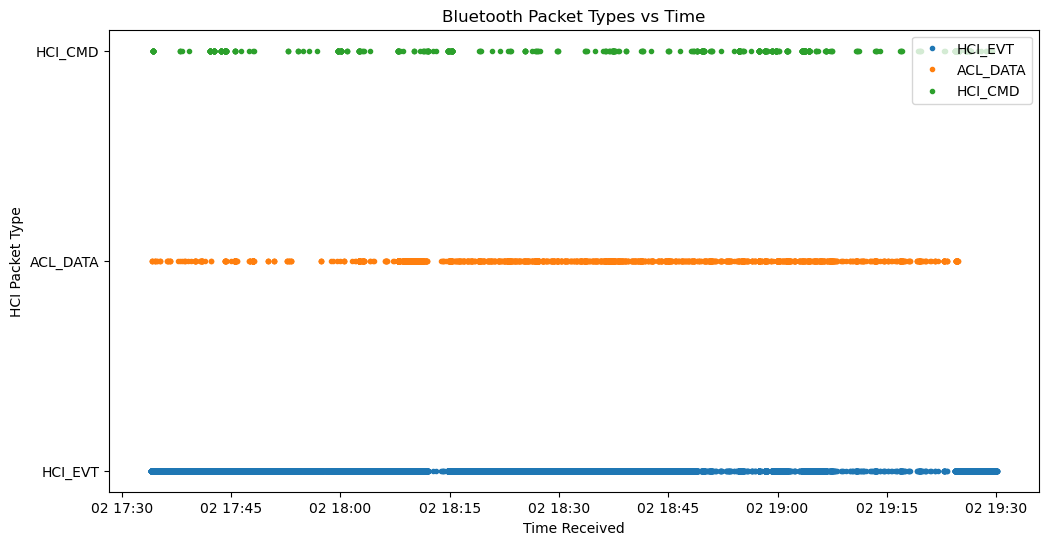

In [93]:
ble_data['time_rcvd'] = pd.to_datetime(ble_data['time_rcvd'])

plt.figure(figsize=(12, 6))
for pkt_type in ble_data['hci_packet_type'].unique():
    subset = ble_data[ble_data['hci_packet_type'] == pkt_type]
    plt.plot(subset['time_rcvd'], subset['hci_packet_type'], '.', label=pkt_type)

plt.xlabel('Time Received')
plt.ylabel('HCI Packet Type')
plt.title('Bluetooth Packet Types vs Time')
plt.legend(loc='upper right')
plt.show()